In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchsummary import summary

import albumentations as album

#!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [2]:
#Defining train / val / test directories
DATA_DIR = 'Three_Phases_Segmentation/datasets/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

list = os.listdir(y_train_dir) # dir is your directory path
number_files = len(list)
print('len_train: ',number_files)

x_valid_dir = os.path.join(DATA_DIR, 'validation')
y_valid_dir = os.path.join(DATA_DIR, 'validation_labels')

list = os.listdir(y_valid_dir) # dir is your directory path
number_files = len(list)
print('len_valid: ',number_files)

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

list = os.listdir(y_test_dir) # dir is your directory path
number_files = len(list)
print('len: ',number_files)

len_train:  228
len_valid:  66
len:  66


In [3]:
#All dataset classes and their corresponding RGB values in labels
class_dict = pd.read_csv("Three_Phases_Segmentation/label_class_dict.csv")
# Get class names
select_classes = class_dict['name'].tolist()
# Get class RGB values
select_class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', select_classes)
print('Class RGB values: ', select_class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['pore', 'grain', 'water', 'air-grain', 'air-water', 'grain-water']
Class RGB values:  [[255, 255, 255], [0, 0, 0], [255, 0, 0], [0, 0, 255], [0, 255, 0], [255, 255, 0]]


In [4]:
#Helper functions for one-hot encoding/decoding
# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [5]:
class BuildingsDataset(torch.utils.data.Dataset):

    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        
        self.lr_transform = transforms.Compose([transforms.ToTensor()])
                    
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        return self.lr_transform(image), self.lr_transform(mask)
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)
    
# Defining Augmentations
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=128, width=128, always_apply=True),
        album.OneOf([album.HorizontalFlip(p=1),
                     album.VerticalFlip(p=1),
                     album.RandomRotate90(p=1)], p=0.5)]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    test_transform = [
        album.RandomCrop(height=128, width=128, always_apply=True)]
    return album.Compose(test_transform)

In [6]:
# Get train and val dataset instances
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir, 
    augmentation= get_training_augmentation(),
    class_rgb_values=select_class_rgb_values) 

print('len_train_dataset: ',len(train_dataset))

valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation= get_validation_augmentation(), 
    class_rgb_values=select_class_rgb_values)

print('len_valid_dataset: ',len(valid_dataset))

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, drop_last=True)

len_train_dataset:  228
len_valid_dataset:  66


In [7]:
#Model Definition
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ENCODER_DEPTH=5
CLASSES = select_classes
ACTIVATION = 'softmax2d' #'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_depth=ENCODER_DEPTH,
    encoder_weights=ENCODER_WEIGHTS, 
    decoder_use_batchnorm=True,
    decoder_channels=(256, 128, 64, 32, 16),#same legnth as encoder_depth
    in_channels=3,#rgb
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

In [8]:
# Set Hyperparams
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 500

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
#loss = smp.utils.losses.constants.MULTICLASS_MODE()
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5)]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-5, weight_decay=0.0001)])#

# define learning rate scheduler 
"""
lmbda = lambda epoch: 0.947 #0.65** epoch
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)
"""

# load best saved model checkpoint from previous commit (if present)
if os.path.exists('best_model_previous_run/best_model.pth'):
    model = torch.load('best_model_previous_run/best_model.pth', map_location=DEVICE)

In [9]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [10]:
# Training 
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # update the learning rate
        """
        lr_scheduler.step(i)
        for param_group in optimizer.param_groups:
            print("LEARNING RATE: ", param_group['lr'])
            usedLr = float(param_group['lr'])
        """

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, 'best_model_current_run/best_model.pth')
            print('Model saved!')

        # evaluate on the test dataset
        # evaluate(model, data_loader_test, device=device)


Epoch: 0
valid: 100%|███████████████████████████████████| 4/4 [00:00<00:00, 10.32it/s, dice_loss - 0.852, iou_score - 1.923e-06]
Model saved!

Epoch: 1
valid: 100%|███████████████████████████████████| 4/4 [00:00<00:00, 10.45it/s, dice_loss - 0.8584, iou_score - 0.001989]
Model saved!

Epoch: 2
valid: 100%|████████████████████████████████████| 4/4 [00:00<00:00, 10.36it/s, dice_loss - 0.8601, iou_score - 0.01057]
Model saved!

Epoch: 3
valid: 100%|████████████████████████████████████| 4/4 [00:00<00:00, 10.31it/s, dice_loss - 0.8589, iou_score - 0.01721]
Model saved!

Epoch: 4
valid: 100%|████████████████████████████████████| 4/4 [00:00<00:00,  9.70it/s, dice_loss - 0.8528, iou_score - 0.02689]
Model saved!

Epoch: 5
valid: 100%|████████████████████████████████████| 4/4 [00:00<00:00,  9.72it/s, dice_loss - 0.8491, iou_score - 0.03369]
Model saved!

Epoch: 6
valid: 100%|████████████████████████████████████| 4/4 [00:00<00:00,  9.86it/s, dice_loss - 0.8394, iou_score - 0.04817]
Model saved!

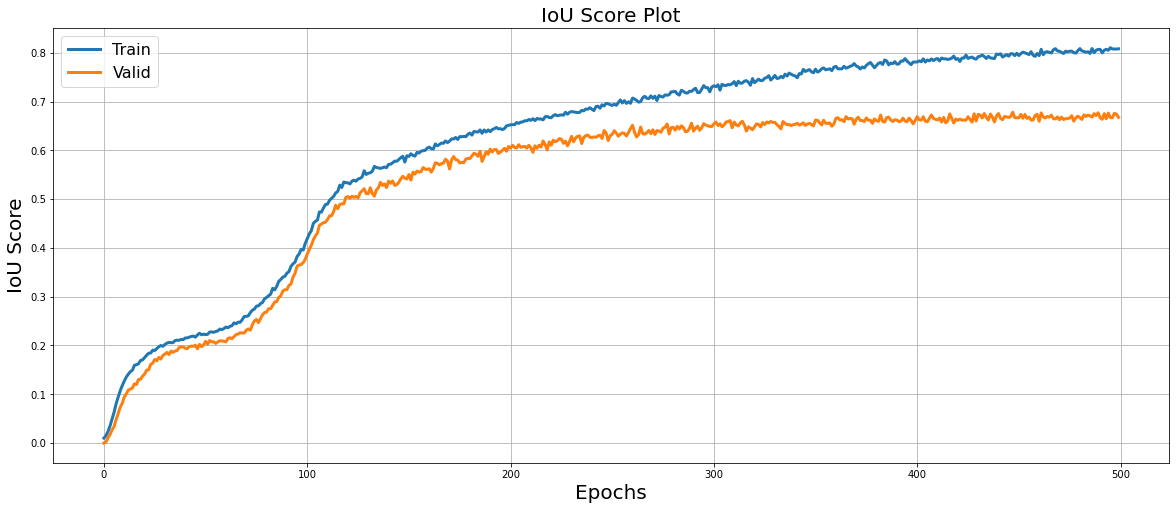

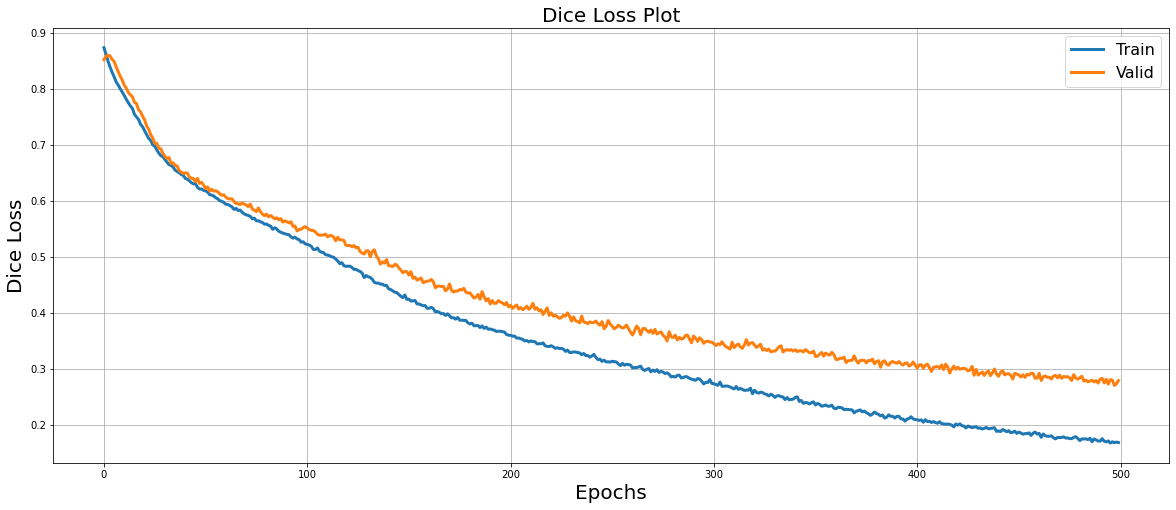

In [11]:
#Plot Dice Loss & IoU Metric for Train vs. Val
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)

plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

In [12]:
# Prediction on Test Data
# load best saved model checkpoint from the current run
if os.path.exists('best_model_current_run/best_model.pth'):
    best_model = torch.load('best_model_current_run/best_model.pth', map_location=DEVICE)
    print('Loaded model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('best_model_previous_run/best_model.pth'):
    best_model = torch.load('best_model_previous_run/best_model.pth', map_location=DEVICE)
    print('Loaded model from a previous commit.')

Loaded model from this run.


In [13]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir, y_test_dir, 
    augmentation= get_validation_augmentation(), 
    class_rgb_values=select_class_rgb_values)

print('len_test_dataset: ',len(test_dataset))

# Get test loaders
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

# Model Evaluation on Test Dataset
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_loader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

len_test_dataset:  66
valid: 100%|█████████████████████████████████████| 4/4 [00:00<00:00,  8.80it/s, dice_loss - 0.2773, iou_score - 0.6742]
Evaluation on Test Data: 
Mean IoU Score: 0.6742
Mean Dice Loss: 0.2773


Original Images
GT Images
Output Images


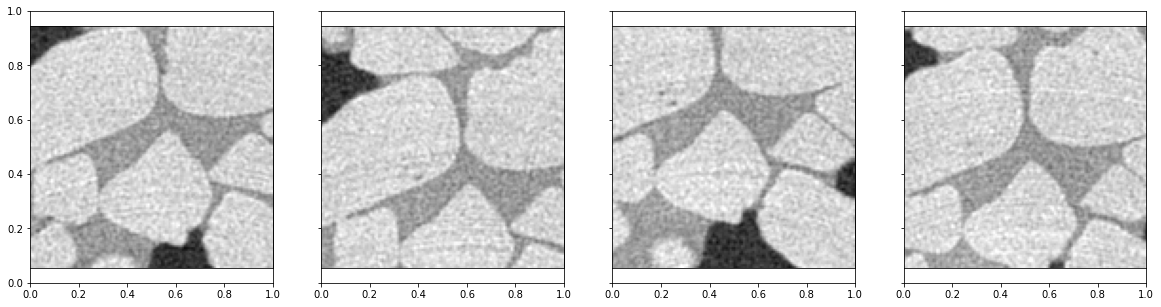

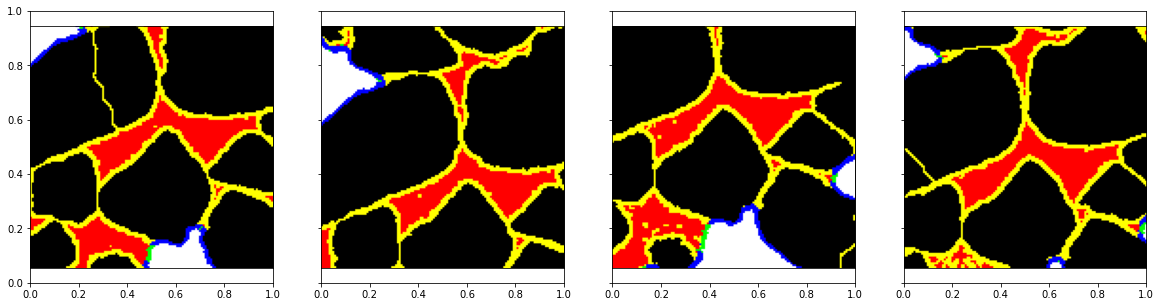

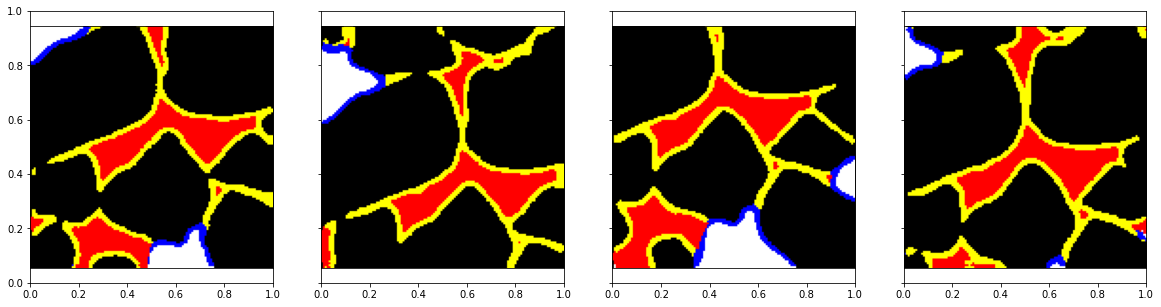

In [14]:
#Batch of train images
dataiter = iter(test_loader)
imgs = dataiter.next()
images, GT = imgs
        
best_model.eval()
with torch.no_grad():
    #Sample outputs
    output = best_model(images.to(DEVICE))

    output = output.cpu()
    output = output.view(16, 6, 128, 128)
    output = output.detach().numpy()

    #Original Images
    print("Original Images")
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20,5))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        ax.imshow(np.transpose(np.squeeze(images.cpu().detach().numpy()[idx]),(1, 2, 0)))
        
    #GT Images
    print("GT Images")
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20,5))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        ax.imshow(colour_code_segmentation(reverse_one_hot(np.transpose(np.squeeze(GT.cpu().detach().numpy()[idx]),(1, 2, 0))),select_class_rgb_values))

    #OutputImages
    print("Output Images")
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20,5))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        ax.imshow(colour_code_segmentation(reverse_one_hot(np.transpose(np.squeeze(output[idx]),(1, 2, 0))),select_class_rgb_values))